<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/%EB%AA%A8%EC%9D%983.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root {--jp-notebook-max-width: 3000px;}</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 기계학습 (60점)

### 리그오브레전드 게임 로그 데이터
data_path = './data/game_result.csv'     
data_path = './data/log.csv'

데이터는 리그오브레전드 게임의 로그 데이터이다.    

---
리그오브 레전드 게임 룰
- 5명의 플레이어가 각자 다른 포지션에서 성장을 통해 아이템과 레벨을 올려 상대의 기지를 파괴하는 AOS장르의 게임
- 두 팀(red,blue)이 격돌, 각 팀은 5명의 플레이어가 5개의 포지션('T', 'J', 'M', 'B', 'S')을 하나씩 맡는다.   
---
데이터 설명
- game_result.csv : 게임 결과에 대한 정보
    - gameId: 게임명
    - win : 승리여부 True-승리, False-패배
    - TEAM: 팀 정보 (rea,blue)
    
- log.csv : 인게임 정보
    - time : 게임의 5분간격(~25분까지)
    - gameId : 게임명
    - variable : 6가지의 특정 행동 정보
        - minionsKilled : 누적 몬스터 킬수
        - totalGold : 누적 골드획득량
        - totalDamageTaken : 누적 피해량
        - totalDamageDone : 누적 데미지
        - WARD_PLACED : 누적 시야 정보량
        - WARD_KILL : 누적 시야 제거량


In [3]:
import pandas as pd
gr =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/game_result.csv')
display(gr.head())

log =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/log.csv')
display(log.head())

,gameId,win,TEAM
0,JP1_340505476,False,blue
1,JP1_340505476,True,red
2,JP1_340611094,True,red
3,JP1_340611094,False,blue
4,JP1_340621330,True,red


,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue


### 기계학습1
인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값으로 채워넣어라      

<img src="./data/1.png" alt="alt_text" style="width:500px; float:left; ">

In [4]:
log['each_variable'] = log.groupby(['gameId','variable','POSITION','TEAM'])['value'].diff().combine_first(log['value'])

### 기계학습2
하나의 행에 하나의 인게임 정보를 넣는 작업을 하고 blue 팀의 승패유무와 관련한 데이터를 추가하려한다.     
아래의 전처리 조건을 확인하여 작업을 진행하라

변환할 데이터프레임의 컬럼정보
- gameId (게임아이디)
- {팀명}_{포지션}_{variable} 형식으로 컬럼을 추가한다. variable 별로 아래 조건을 만족하는 값을 채워 넣는다.
    - {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다.
    - {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
    - {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
    - {팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가한다.
- result : blue팀의 승리여부, 승리 : 1 , 패배 : 0

아래와 같이 62개의 컬럼이 완성된다.    
<img src="./data/2.png" alt="alt_text" style="width:500px; float:left; ">

In [5]:
# target
log['target'] = log['TEAM'] + log['POSITION'] + log['variable']

# 1. minionsKilled
m = log[(log['variable'] =='minionsKilled') & (log['time'] == 25)]
pivot_minion = m.pivot_table(columns = ['target'] , values = 'value', index = 'gameId')


In [6]:
# 2.totalGold
gold = log[log['variable'] =='totalGold']
group_gold = gold.groupby(['target','gameId'])['each_variable'].mean().reset_index()
pivot_gold = group_gold.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

In [7]:
# 3. {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가
damage = log[log['variable'] =='totalDamageTaken']
group_damage = gold.groupby(['target','gameId'])['each_variable'].mean().reset_index()
pivot_damage = group_gold.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

In [8]:
# 4. {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
done = log[log['variable'] =='_totalDamageDone']
group_done = gold.groupby(['target','gameId'])['each_variable'].var().reset_index()
pivot_done = group_gold.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

In [9]:
# 5. {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가
ward = log[(log['variable'] =='_WARD_PLACED') & (log['time'] == 15)]
pivot_ward = m.pivot_table(columns = ['target'] , values = 'value', index = 'gameId')
pivot_ward.head(4)

target,blueBminionsKilled,blueJminionsKilled,blueMminionsKilled,blueSminionsKilled,blueTminionsKilled,redBminionsKilled,redJminionsKilled,redMminionsKilled,redSminionsKilled,redTminionsKilled
gameId,,,,,,,,,,
JP1_340505476,54.0,14.0,140.0,168.0,188.0,168.0,22.0,167.0,52.0,173.0
JP1_340611094,181.0,28.0,197.0,26.0,169.0,194.0,48.0,148.0,17.0,155.0
JP1_340621330,192.0,61.0,202.0,37.0,97.0,189.0,15.0,147.0,24.0,183.0
JP1_340652067,203.0,68.0,166.0,36.0,191.0,217.0,22.0,177.0,34.0,148.0


In [10]:
# 6.{팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가
kill = log[log['variable'] =='_WARD_KILL']
kill_done = gold.groupby(['target','gameId'])['each_variable'].var().reset_index()
pivot_kill = group_gold.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

In [11]:
# game result
blue = gr[gr['TEAM'] == 'blue'].reset_index(drop = True)
blue['result'] = blue['win'].astype(int)
blue_result = blue.drop(columns = ['win','TEAM']).set_index('gameId')

In [12]:
final_df = pd.concat([pivot_minion, pivot_gold, pivot_damage, pivot_done, pivot_ward , pivot_kill, blue_result], axis = 1).reset_index()

### 기계학습 3
데이터 EDA 및 시각화

### 기계학습4      
전처리한 데이터를 바탕으로 승리 예측 분류 모델을 만들려고한다. 아래의 기준으로 모델링을 하고 평가를 진행하라     
- 랜덤포레스트와 그래디언트 부스팅으로 학습한다
- 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터를 찾는다.   
- 학습데이터는 70%를 사용한다
- auc값으로 평가를 진행하며 ROC Curve를 그려라

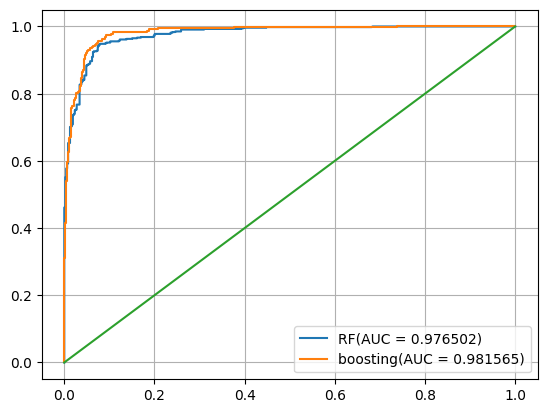

,Models,Accuracy_score
0,RF,0.928924
1,boosting,0.937808


In [13]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve , accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

X = final_df.drop(columns = ['gameId' , 'result'] , axis = 1)
y = final_df['result']


def eval_model(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

  # 1.pipeline
  pipe = Pipeline([
      ('scaler' , StandardScaler()) ,
      ('model', model)
  ])

  if name == 'RF' :
    param_grid = {
            'model__n_estimators': [1, 10, 100],
            'model__min_samples_split': [2, 3, 4],
            'model__min_samples_leaf': [1, 2]
        }

  elif name =='boosting' :
    param_grid = {
        'model__learning_rate' : [0.1, 0.5, 1] ,
        'model__n_estimators' : [1, 10, 100] ,
        'model__min_samples_split' : [2,4,6] # min_sample_split cannot be 1, changed to 2
    }

  grid = GridSearchCV(pipe, param_grid, cv = 3, scoring = 'accuracy')
  grid.fit(x_train, y_train)
  best = grid.best_estimator_

  # best_
  pred = best.predict(x_test)
  acc = accuracy_score(y_test, pred)

  # roc_curve
  pred_proba = best.predict_proba(x_test)[:,1]
  fpr, tpr, _ = roc_curve(y_test, pred_proba)
  auc = roc_auc_score(y_test, pred_proba)
  plt.plot(fpr, tpr, label = f'{name}(AUC = {auc:2f})')

  return name, acc, best

res =[]
model_lst = []
for name, model in [['RF',RandomForestClassifier()] , ['boosting' , GradientBoostingClassifier()]] :
  name, acc, best = eval_model(name, model)
  res.append([name, acc])
  # Best Model로 저장하기
  model_lst.append([name, best])


plt.plot([0,1], [0,1])
plt.grid(True)
plt.legend()
plt.show()

display(pd.DataFrame(res, columns =['Models','Accuracy_score']))

### 기계학습5
성능이 우수한 모델로부터 변수중요도를 시각화하고 해석하라

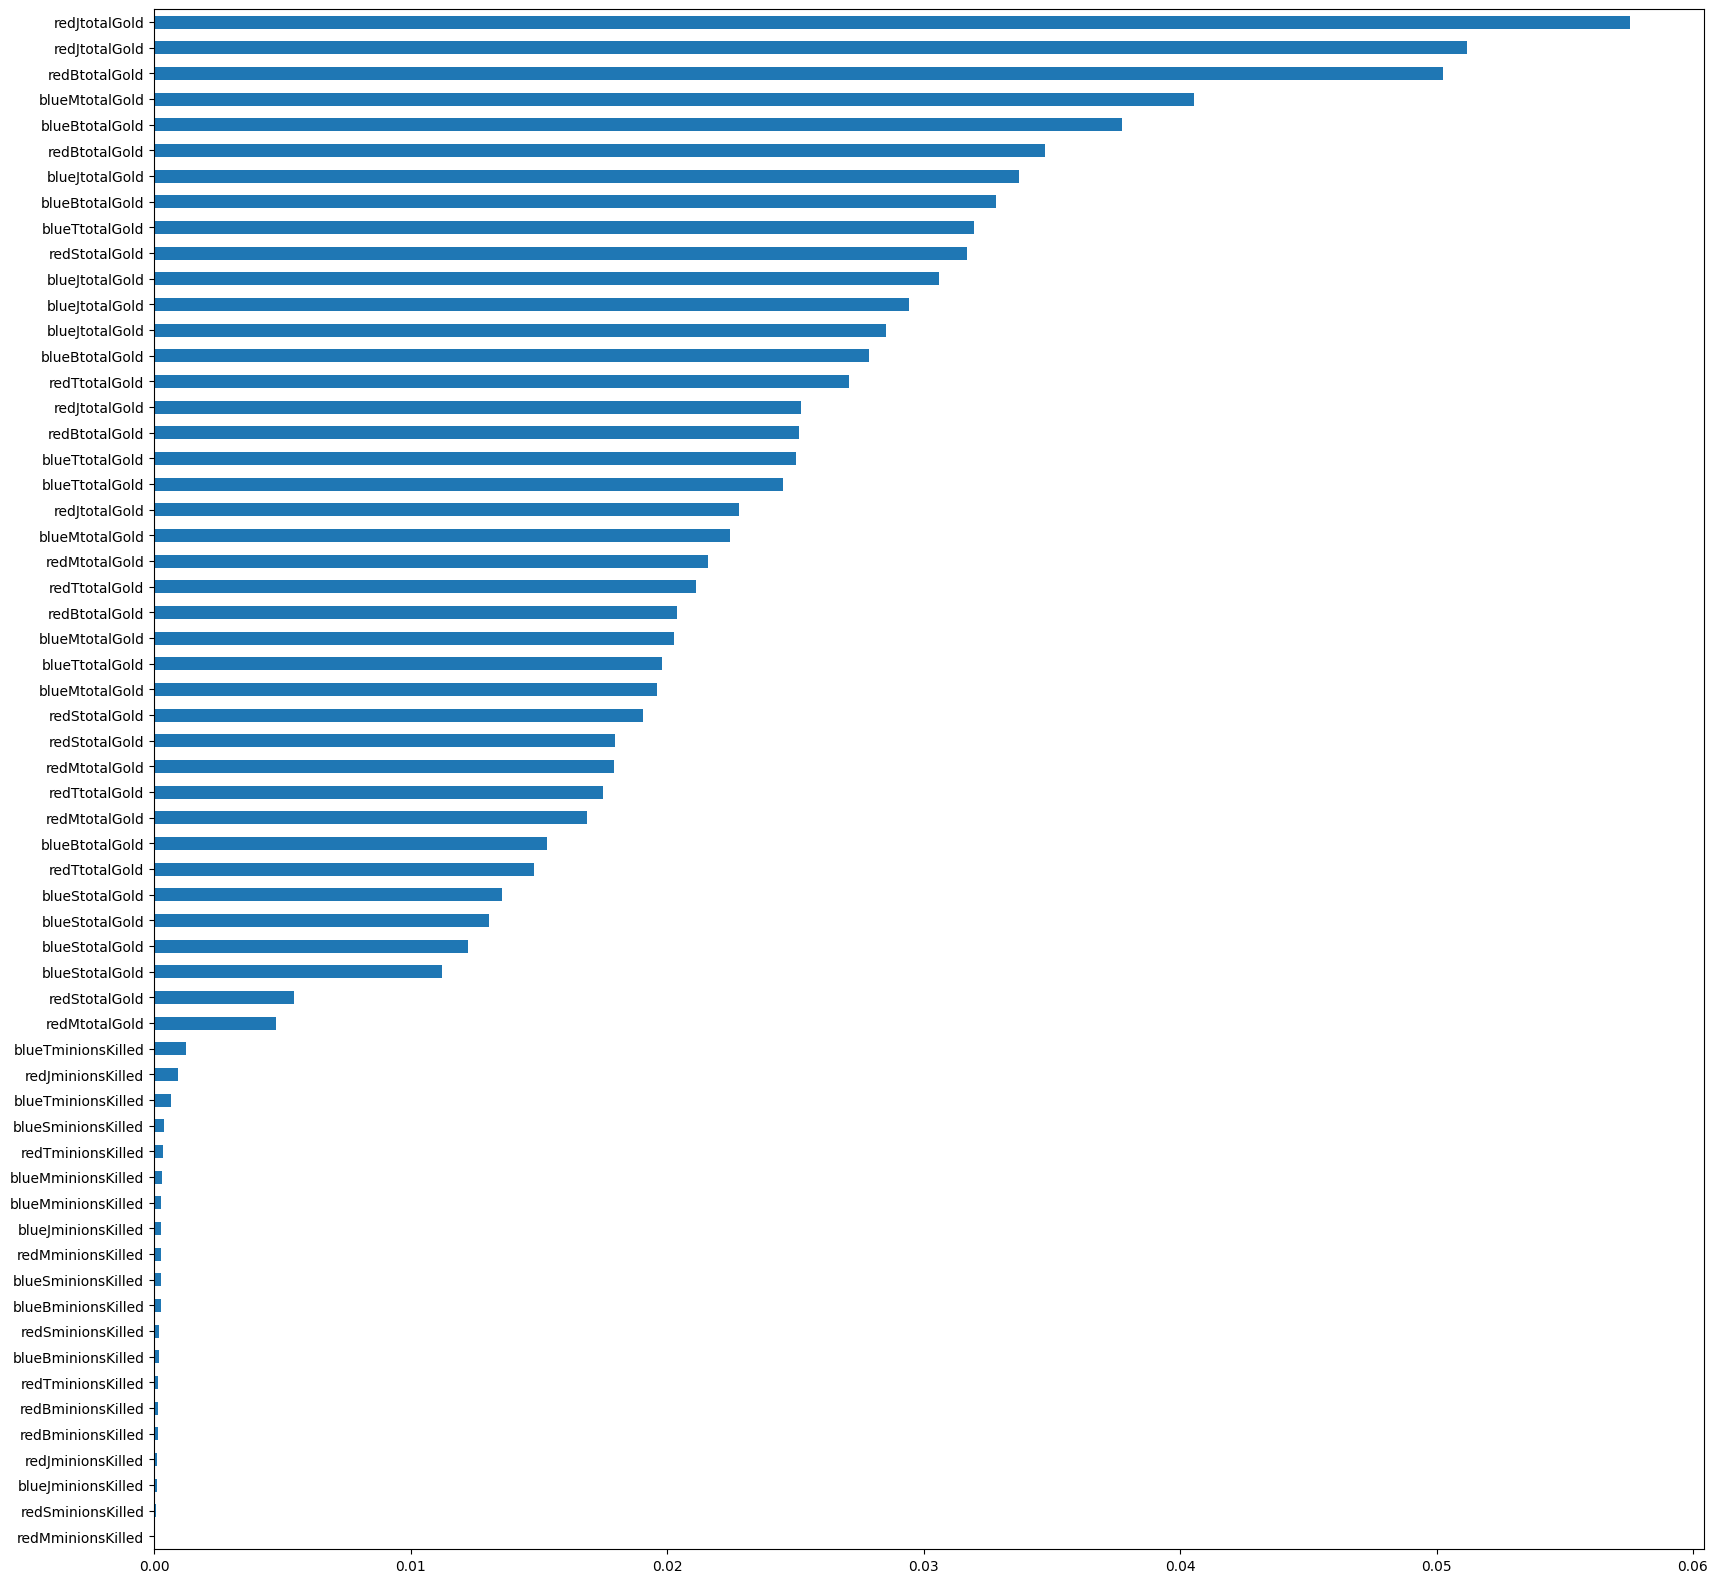

In [14]:
for name, model in model_lst :
  if name == 'boosting' :
    features = X.columns
     # model.named_steps 함수로 model만 빼오기
    imp = model.named_steps['model'].feature_importances_
    imp_df = pd.Series(imp, index = features).sort_values()

    imp_df.plot.barh(figsize = (20,20)) # Use the pandas Series for plotting

### 폐처리 시설의 여러 대기 측정정보

data_path = './data/mc.csv'

데이터는 특정 폐수 처리시설 주변의 여러 측정센서를 통해 5분간격으로 측정한 데이터이다.
- 매 5분동안 최대 24개의 주변 측정소에서 여러 정보들을 수집한다.

In [15]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/mc.csv')
df.head()

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


### 기계학습5    
다음의 기준으로 전처리를 시행하고 시각화를 포함한 EDA를 진행하라
1. 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라.
2. 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거하라

In [16]:
df['측정일시'] = pd.to_datetime(df['측정일시'])

In [17]:
df1 = df.copy()
# groupby- max함수를 쓰면 각 컬럼에서의 최대값만 나옴
df_max = df1.groupby(['측정일시']).max().reset_index()
df_max['sum'] = df_max.iloc[:,2:].sum(axis =1)


# 측정일시, 측정장소 drop
filter_df = df_max[df_max['sum']!=0].drop(columns = ['sum','측정장소'], axis = 1)


### 기계학습6     
데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라.
각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가한다.

In [18]:
def time_split(row) :
  x = row['측정일시'].hour

  if x in range(0, 6) :
    return 0
  elif x in range(6, 12) :
    return 1
  elif x in range(12, 18):
    return 2
  else :
    return 3

filter_df['date_split'] = filter_df.apply(time_split, axis = 1)
filter_df.iloc[:,1:].groupby('date_split').mean()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
date_split,,,,,,,,,,
0,19.126401,69.820901,0.919857,0.179624,14.147446,22.089773,1095.190737,0.0,920.996830,202.418843
1,20.663905,61.973266,0.920474,0.234525,12.297990,30.679407,881.189087,0.0,921.539455,220.300726
2,22.305817,51.730485,0.921526,0.399507,11.160184,53.691182,313.207611,0.0,924.846586,207.866152
3,19.865287,64.029254,0.918815,0.251769,13.999310,40.416470,529.772975,0.0,922.313887,194.727311


### 기계학습7     
5번에서 전처리한 데이터의 변수간 상관관계를 확인하라.    
date_split의 값이 2과 3인 데이터만 필터하고 각 온도~초미세먼지의 컬럼이 date_split 값에 따른 차이가 존재하는지 통계검정하라

In [19]:
cor_df = filter_df.drop(columns = ['측정일시','date_split','강수량'])
cor_df.corr(method = 'spearman')

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
온도,1.000000,0.215858,0.322877,0.339797,-0.151304,0.335138,-0.130011,-0.358907,0.229556
습도,0.215858,1.000000,0.276171,-0.101411,0.237941,0.581576,0.347012,-0.070733,0.372446
풍향,0.322877,0.276171,1.000000,0.457438,0.452365,0.434567,0.443272,0.455852,0.456652
풍속,0.339797,-0.101411,0.457438,1.000000,0.109181,0.138343,0.143061,0.123885,0.080995
황화수소,-0.151304,0.237941,0.452365,0.109181,1.000000,0.278394,0.383300,0.466901,0.208884
암모니아,0.335138,0.581576,0.434567,0.138343,0.278394,1.000000,0.193225,0.001860,0.291688
휘발성유기화합물,-0.130011,0.347012,0.443272,0.143061,0.383300,0.193225,1.000000,0.472897,0.358699
기압,-0.358907,-0.070733,0.455852,0.123885,0.466901,0.001860,0.472897,1.000000,0.250857
초미세먼지,0.229556,0.372446,0.456652,0.080995,0.208884,0.291688,0.358699,0.250857,1.000000


In [20]:
from scipy.stats import ttest_ind

df23 = filter_df[filter_df['date_split'].isin([2,3])].drop(columns = ['측정일시','강수량'])

res =[]
for col in df23.columns.difference(['date_split']) :
  g1 = df23[df23['date_split'] ==2][col]
  g2 = df23[df23['date_split'] ==3][col]

  stat, p_val = ttest_ind(g1, g2)
  decision = '차이가 있다(유의하다)' if p_val < 0.05 else '유의하지 않다'
  res.append({
      'Columns' : col,
      'P_value' : round(p_val,4),
      'Decision' : decision
  })

display(pd.DataFrame(res))


,Columns,P_value,Decision
0,기압,0.5423,유의하지 않다
1,습도,0.0000,차이가 있다(유의하다)
2,암모니아,0.0000,차이가 있다(유의하다)
3,온도,0.0000,차이가 있다(유의하다)
4,초미세먼지,0.0117,차이가 있다(유의하다)
5,풍속,0.0000,차이가 있다(유의하다)
6,풍향,0.4763,유의하지 않다
7,황화수소,0.0000,차이가 있다(유의하다)
8,휘발성유기화합물,0.0000,차이가 있다(유의하다)


### 기계학습 8
전처리한 데이터를 바탕으로 초미세먼지를 예측하는 모델을 만들려고한다.     
적절한 변수 처리를 하고 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가를 실시하라.
rmse로 평가를 진행한다.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X = filter_df.drop(columns =['측정일시','date_split','초미세먼지'])
y = filter_df['초미세먼지']

res = []
def eval(name, model) :
  x_train, x_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  pipe = Pipeline([
      ('scaler' , StandardScaler()) ,
      ('model', model)
  ])

  pipe.fit(x_train, y_train)
  pred = pipe.predict(x_test)

  rmse = np.sqrt(mean_squared_error(y_test, pred))

  return name, rmse


res = []
for name, model in [['LR', LinearRegression()] ,['RF',RandomForestRegressor()]] :
  name, rmse = eval(name, model)
  res.append([name, rmse])

result = pd.DataFrame(res, columns = ['Model','RMSE'])
print(result)

  Model        RMSE
0    LR  347.483761
1    RF  122.398330


# 통계 (40점)

## 통계1

### 통계1-1      
어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다.      
최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률은?     

In [22]:
from scipy.stats import expon

rv = expon(scale = 10)

# 시점의 영향을 받지 않음 지수분포 5년이 지난 것은 무시
print(1 - rv.cdf(7))

# 5년이 지남을 조건으로 쓰면
print((1 - rv.cdf(12)) / (1 - rv.cdf(5)))

0.4965853037914095
0.4965853037914097


### 통계 1-2
지난 지진 발생 후 15년이 지났다. 8년 이내에 지진이 발생할 확률은?

In [23]:
print(rv.cdf(8))

0.5506710358827784


## 통계2
data_path = './data/s1.csv'     
데이터는 식단과 운동강도에 따라 감량 체중을 기록한 다이어트 프로그램 결과이다.

In [44]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/s1.csv')
df.head()

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030
4,ID-5,저탄고단,저강도,4.765847


### 통계 2-1
식단과 운동의 조합으로 만들어지는 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인하라    

In [45]:
from scipy.stats import shapiro, levene

res = []
for key, group in df.groupby(['식단','운동']) :
  stat, p_val = shapiro(group['감량체중'])
  decision = '정규분포이다' if p_val > 0.05 else '정규분포가 아니다'
  res.append({
      '조합' : key,
      'Shapiro Pvalue' : p_val,
      'Shapiro Decision' : decision
  })

result = pd.DataFrame(res)

g = [group['감량체중'] for name, group in df.groupby(['식단','운동'])]
stat, leven_p_val = levene(*g)
levene_decision = '등분산이다' if leven_p_val > 0.05 else '등분산이 아니다'

result['Levene p_value'] = leven_p_val
result['Levene Decision'] = levene_decision
display(result)

,조합,Shapiro Pvalue,Shapiro Decision,Levene p_value,Levene Decision
0,"(저탄고단, 고강도)",0.370877,정규분포이다,0.573601,등분산이다
1,"(저탄고단, 저강도)",0.660390,정규분포이다,0.573601,등분산이다
2,"(저탄고지, 고강도)",0.162404,정규분포이다,0.573601,등분산이다
3,"(저탄고지, 저강도)",0.326866,정규분포이다,0.573601,등분산이다


### 통계 2-2
이원분산분석을 진행하려한다. 2-1의 결과를 바탕으로 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정하라    

In [46]:
# 모수적 진행

print('''
주효과
1. 식단
  귀무 : 식단에 상관없이 감량체중의 값은 같다.
  대립 : 적어도 하나의 식단에서 감량 체중이 다르다.

2. 운동
  귀무 : 운동에 상관없이 감량체중의 값은 같다.
  대립 : 적어도 하나의 운동에서 감량 체중이 다르다.

교호작용
  귀무 : 식단과 운동에 교호작용이 없다
  대립 : 식단과 운동에 교호작용이 존재한다.

''')


주효과
1. 식단
  귀무 : 식단에 상관없이 감량체중의 값은 같다.
  대립 : 적어도 하나의 식단에서 감량 체중이 다르다.

2. 운동
  귀무 : 운동에 상관없이 감량체중의 값은 같다.
  대립 : 적어도 하나의 운동에서 감량 체중이 다르다.

교호작용
  귀무 : 식단과 운동에 교호작용이 없다
  대립 : 식단과 운동에 교호작용이 존재한다.




### 통계2-3
통계검정을 실시하고 결과를 해석하라.    



In [47]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('감량체중 ~ C(식단) * C(운동)', data = df).fit()
anova_res = anova_lm(model,typ = 3)
display(anova_res)


,sum_sq,df,F,PR(>F)
Intercept,1426.092878,1.0,1609.912302,4.213332e-84
C(식단),5.077426,1.0,5.731892,1.784665e-02
C(운동),28.302648,1.0,31.950781,7.331859e-08
C(식단):C(운동),0.714673,1.0,0.806792,3.704546e-01
Residual,138.187955,156.0,NaN,NaN


In [63]:
# -----------------------------
# 4-B) 비모수: Scheirer–Ray–Hare + 사후검정(MWU+Bonferroni)
# 1. 주효과 (식단, 운동)
# - Kruskal
# 그룹간 차이가 없다
# 유의할 경우 >> 사후검정

# 2. 사후검정
# - 만 위트니 전쌍 비교
# - Bonferroni 보점
# -----------------------------
from scipy import stats


# ------------------------------------
# 1. Kruskal-Wallis 주효과 검정
# -----------------------------------

# 식단에 대한 Kruskal-Wallis
res = []
diet_group = [group['감량체중'] for name, group in df.groupby('식단')]
stat, p_val = stats.kruskal(*diet_group)
res.append(['식단', p_val])

# 운동에 대한 Kruskal-Wallis
workout_group = [group['감량체중'] for name, group in df.groupby('운동')]
stat, p_val = stats.kruskal(*workout_group)
res.append(['운동', p_val])

# 결과 출력
pd.DataFrame(res, columns=['요인', 'p_value'])


## 사후검정은 요인 조합별로 Mann–Whitney U test
from itertools import combinations
from scipy.stats import mannwhitneyu
# 조합 변수 생성
df['group'] = df['식단'].astype(str) + '_' + df['운동'].astype(str)

groups = df['group'].unique()
pairs = list(combinations(groups, 2))

posthoc = []
for v1, v2 in pairs :
  data1 = df[df['group'] == v1]['감량체중']
  data2 = df[df['group'] == v2]['감량체중']

  stat, p_val = stats.mannwhitneyu(data1, data2, alternative ='two-sided')
  posthoc.append([v1, v2, p_val])

posthoc_df = pd.DataFrame(posthoc, columns = ['v1','v2','p_value'])

# Bonferroni 보정
posthoc_df['Bonferroni'] = posthoc_df['p_value'] * len(posthoc_df)

print(posthoc_df)

         v1        v2       p_value    Bonferroni
0  저탄고단_저강도  저탄고단_고강도  1.206583e-06  7.239497e-06
1  저탄고단_저강도  저탄고지_저강도  2.508770e-04  1.505262e-03
2  저탄고단_저강도  저탄고지_고강도  3.833312e-03  2.299987e-02
3  저탄고단_고강도  저탄고지_저강도  7.533900e-11  4.520340e-10
4  저탄고단_고강도  저탄고지_고강도  2.013435e-02  1.208061e-01
5  저탄고지_저강도  저탄고지_고강도  7.988942e-09  4.793365e-08


### 통계 2-4
사후검정을 실시하고 결과를 해석하라.

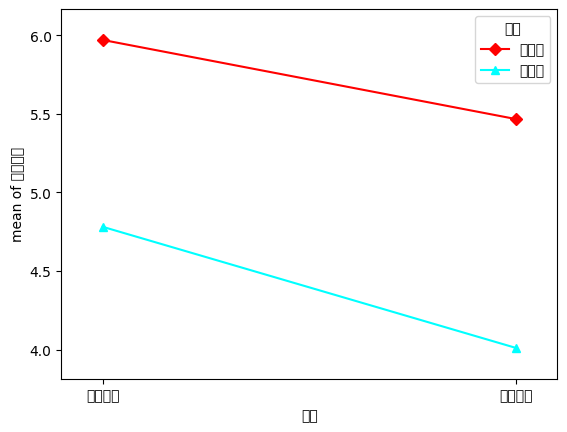

group1,group2,meandiff,p-adj,lower,upper,reject
저탄고단고강도,저탄고단저강도,-1.1896,0.0,-1.7361,-0.6431,True
저탄고단고강도,저탄고지고강도,-0.5039,0.0824,-1.0504,0.0427,False
저탄고단고강도,저탄고지저강도,-1.9608,0.0,-2.5073,-1.4142,True
저탄고단저강도,저탄고지고강도,0.6857,0.0074,0.1392,1.2323,True
저탄고단저강도,저탄고지저강도,-0.7712,0.0019,-1.3177,-0.2247,True
저탄고지고강도,저탄고지저강도,-1.4569,0.0,-2.0035,-0.9104,True


In [28]:
# 모수적 사후 검정
# 교호작용 그림
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Corrected arguments for interaction_plot
interaction_plot(df['식단'], df['운동'], df['감량체중'],  markers=['D', '^'])
plt.show()


from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog = df['감량체중'] , groups = df['식단'] + df['운동'], alpha = 0.05)
tukey.summary()

## 각 요인이 수준이 2개이면, 사후검정은 필요없음

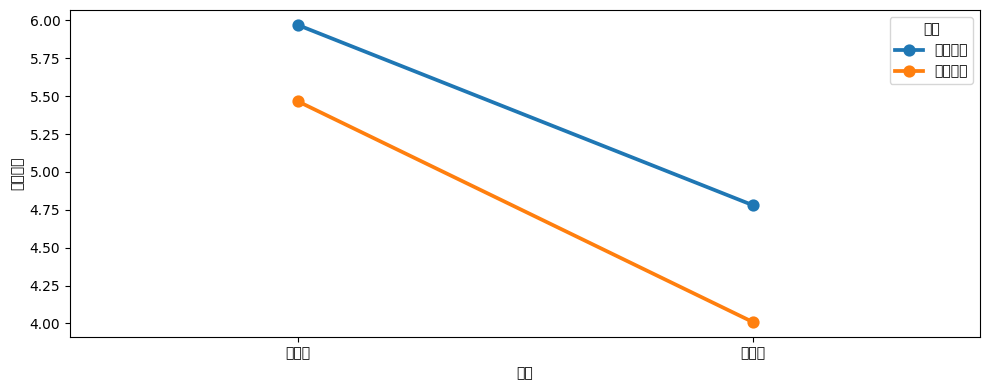

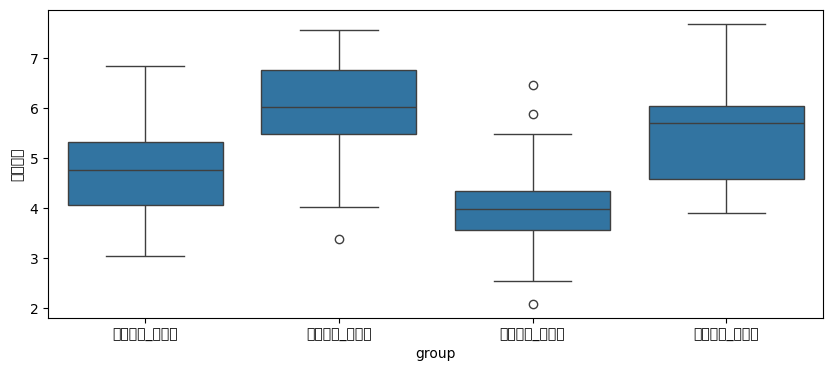

In [66]:
## 비모수 사후검정
import seaborn as sns

avg_df = df.groupby(['식단','운동'])['감량체중'].mean().reset_index()

plt.figure(figsize = (10, 4))
sns.pointplot(data = avg_df,
              x = '운동',
              y = '감량체중',
              hue = '식단')
plt.tight_layout()


plt.figure(figsize = (10, 4))
sns.boxplot(data = df, x = 'group' , y = '감량체중')
plt.show()

## 통계3
data_path = './data/s3.csv'     
나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델을 만드려고 한다.

In [29]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/s3.csv')
df

,Age,EstimatedSalary,Gender,Purchased
0,22,19000,0,0
1,25,20000,1,0
2,47,43000,0,1
3,52,46000,1,1
4,46,22000,1,0
5,56,80000,0,1
6,55,76000,0,1
7,60,83000,1,1
8,62,81000,1,1
9,61,89000,0,1


### 통계3-1
<모델학습조건>    
* 0,2,3,4의 인덱스 데이터를 테스트 데이터로 하고 나머지 행을 학습데이터로 한다.     
* 학습데이터에 Gender를 더미화하고 나이와 봉급은 표준화(Standardization) 하라.     
* 로지스틱 회귀 모델을 학습하고 모델 평가를 실시하여 결과를 출력하라. 훈련데이터와 평가데이터에 대한 각각의 accuracy 값을 출력하라.    

In [34]:
from sklearn.linear_model import LogisticRegression

clean_df = pd.DataFrame()
for col in df.columns :
  if col == 'Purchased' :
    clean_df[col] = df[col]

  elif col in ['Age', 'EstimatedSalary'] :
    ss = StandardScaler()
    clean_df[col] = ss.fit_transform(df[[col]]).flatten()

  else :
    dummies = pd.get_dummies(df[col], prefix = col, dtype = int)
    for d_col in dummies.columns :
      clean_df[d_col] = dummies[d_col]

clean_df

train_set = clean_df[~ clean_df.index.isin([0,2,3,4])]
x_train = train_set.drop(columns = ['Purchased'])
y_train = train_set['Purchased']


test_set = clean_df[clean_df.index.isin([0,2,3,4])]
x_test = test_set.drop(columns = ['Purchased'])
y_test = test_set['Purchased']

lg = LogisticRegression()
lg.fit(x_train, y_train)
pred = lg.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print(test_acc)


pred = lg.predict(x_train)
train_acc = accuracy_score(y_train, pred)
print(train_acc)

0.75
1.0


### 통계3-2
test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출하라

In [35]:
lg.predict_proba(x_test)[3]

array([0.40780504, 0.59219496])

### 통계 3-3
새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값은 다음과 같다.
| Age  | EstimatedSalary | Gender_0 | Gender_1 |
|------|-----------------|--------|-----------|
| -0.6 | -1.8            | 0      | 1         |     


이 데이터에 대한 모델 결과를 예측하려한다.    
변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과를 각각 구하여라

In [36]:
from math import exp
new_x = [-0.6,-1.8,0,1]

# 절편값 뽑아내기
w = lg.coef_.ravel()

# 상수항
b = float(lg.intercept_[0])

# Z값 계산 : b + np.dot(w , new_x)
z = b + np.dot(w, new_x)

# signmoid
sigmoid  = 1.0 / (1.0 + exp(-z))
print(sigmoid )

0.42247378663829876


### 통계 3-4
3-1에서 학습한 모델의 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인하라

In [37]:
# 회귀계수 출력
odds = np.exp(lg.coef_[0])
odds

array([2.11251301, 1.96466028, 1.19079864, 0.83979769])

In [38]:
### 전처리 연습하기
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/mc.csv')
df.head()

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


In [39]:
# 문제1) 측정일시별로 측정장소에 관계없이, 모든 수치형 변수 중 최대값을 가진 행만 남기는 코드를 작성하시오.
# 단, 측정장소, 측정일시는 그룹 기준 변수이며 계산에서 제외

num_cols = df.select_dtypes(exclude = 'object').columns.drop('측정장소', errors = 'ignore')

# MAX 값
df['_max_val'] = df[num_cols].max(axis = 1)

df_max_by_ts = df.loc[df.groupby('측정일시')['_max_val'].idxmax()].reset_index(drop=True)
df_max_by_ts

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지,_max_val
0,11,2022-01-10 09:00:00,12.07,81.43,1.0,0.08,10.0,0.0,5849.5,0,1023.2,0.0,5849.5
1,11,2022-01-10 09:05:00,12.22,81.15,0.9,0.06,10.0,0.0,6236.0,0,1023.2,0.0,6236.0
2,11,2022-01-10 09:10:00,12.34,80.38,1.0,0.11,8.0,0.0,6045.8,0,1023.1,0.0,6045.8
3,11,2022-01-10 09:15:00,12.44,79.65,1.0,0.10,8.0,0.0,5617.0,0,1023.2,0.0,5617.0
4,11,2022-01-10 09:20:00,12.56,78.70,0.9,0.07,8.0,0.0,5261.0,0,1023.2,0.0,5261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40784,11,2022-05-31 23:40:00,25.17,42.07,-1.0,0.21,0.0,0.0,0.0,0,1007.2,0.0,1007.2
40785,11,2022-05-31 23:45:00,25.17,41.63,-1.0,0.28,0.0,0.0,0.0,0,1007.1,0.0,1007.1
40786,11,2022-05-31 23:50:00,25.11,41.68,-1.0,0.26,0.0,0.0,0.0,0,1007.1,0.0,1007.1
40787,11,2022-05-31 23:55:00,25.11,41.80,-1.0,0.26,0.0,0.0,0.0,0,1007.1,0.0,1007.1


In [40]:
# 문제2) 특정 값 조건 필터링 (np.where)
# 황화수소 값이 10 이상이면 "High",
# 그 외에는 "Normal"이라는 새로운 컬럼(H2S_level)을 생성하시오.
# np.where를 사용해야 하며, 값이 결측인 경우 "Missing"으로 처리한다.

np.where(
    df['황화수소'].isna() , 'Missing',
    np.where(df['황화수소'] >= 10, 'High','Normal')
)

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype='<U7')

In [41]:
#문제 3. 다중 조건 처리
#암모니아가 5 이상 또는 휘발성유기화합물이 100 이상이면 "Warning"
#황화수소가 0이면 "Safe"
#나머지는 "Normal"
#np.select를 활용할 것.

condition = [
    (df['암모니아'] >= 5) | (df['휘발성유기화합물'] >= 100) ,
    (df['황화수소'] == 0)
]

labels = ['Warning','Safe']

np.select(condition, labels, default = 'Normal')

array(['Safe', 'Normal', 'Normal', ..., 'Safe', 'Safe', 'Safe'],
      dtype='<U7')

In [42]:
#문제 5. 그룹별 최대-최소 차이
#측정일시별로 온도의 (최대값 - 최소값)을 구하여 temp_range라는 새로운 DataFrame을 생성하시오.

df.groupby('측정일시')['온도'].agg(temp_max = 'max' ,
                                   temp_min = 'min').assign(temp_range = lambda x : x['temp_max'] - x['temp_min']).reset_index().head(4)

,측정일시,temp_max,temp_min,temp_range
0,2022-01-10 09:00:00,16.67,0.0,16.67
1,2022-01-10 09:05:00,16.78,0.0,16.78
2,2022-01-10 09:10:00,16.86,0.0,16.86
3,2022-01-10 09:15:00,17.01,0.0,17.01
